In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon

## Geographical Heat Map

### Importing the number of business applications

Taking our existing data of business applications and importing as a DataFrame

In [160]:
df_biz = pd.read_csv("data05-22/biz_apps_new.csv")
df_biz = df.rename(columns={"State":"STATE"}).round(2)
df_biz.head()

,Name,STATE,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Alabama,AL,31078,33918,33701,32222,29221,29916,28994,29694,29331,29574,31506,34286,36760,41948,41478,58557,75443,70750
1,Alaska,AK,4730,5229,5138,4979,4396,4661,5083,5210,5383,5447,5901,6358,7263,9238,8118,8063,8063,8456
2,Arizona,AZ,56547,63067,64673,62972,58279,57926,57837,55305,55516,56401,57176,61448,67833,73424,76539,89957,113142,115080
3,Arkansas,AR,19133,20400,19630,18707,17927,17843,17939,17812,17551,18445,19033,20445,23135,25678,25473,32314,41599,37562
4,California,CA,271636,286652,286737,271606,249246,256436,270057,268103,278014,293443,303657,312636,326592,364807,364924,438554,519236,485954


### Importing the geographical file for the US states

Using geopandas, we create a dataframe of the US States with their name, longitude, latitude and geometry

In [84]:
shapefile = 's_08mr23/s_08mr23.shp'
gdf = gpd.read_file(shapefile)
gdf.head()

,STATE,NAME,FIPS,LON,LAT,geometry
0,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
1,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
2,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-168.14924 -14.53377, -168.148..."
3,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0..."
4,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263..."


In [85]:
#drop Puerto rico, Fed States of Micronesia, American Samoa, US Virgin Islands, Guam, Commonwealth of the northern mariana islands from file
gdf = gdf.drop(index=[2,37,44,52,54,55,56,57])
gdf = gdf.reset_index(drop=True)

In [86]:
len(gdf) #it is the same as len(df)

51

<IPython.core.display.Javascript object>


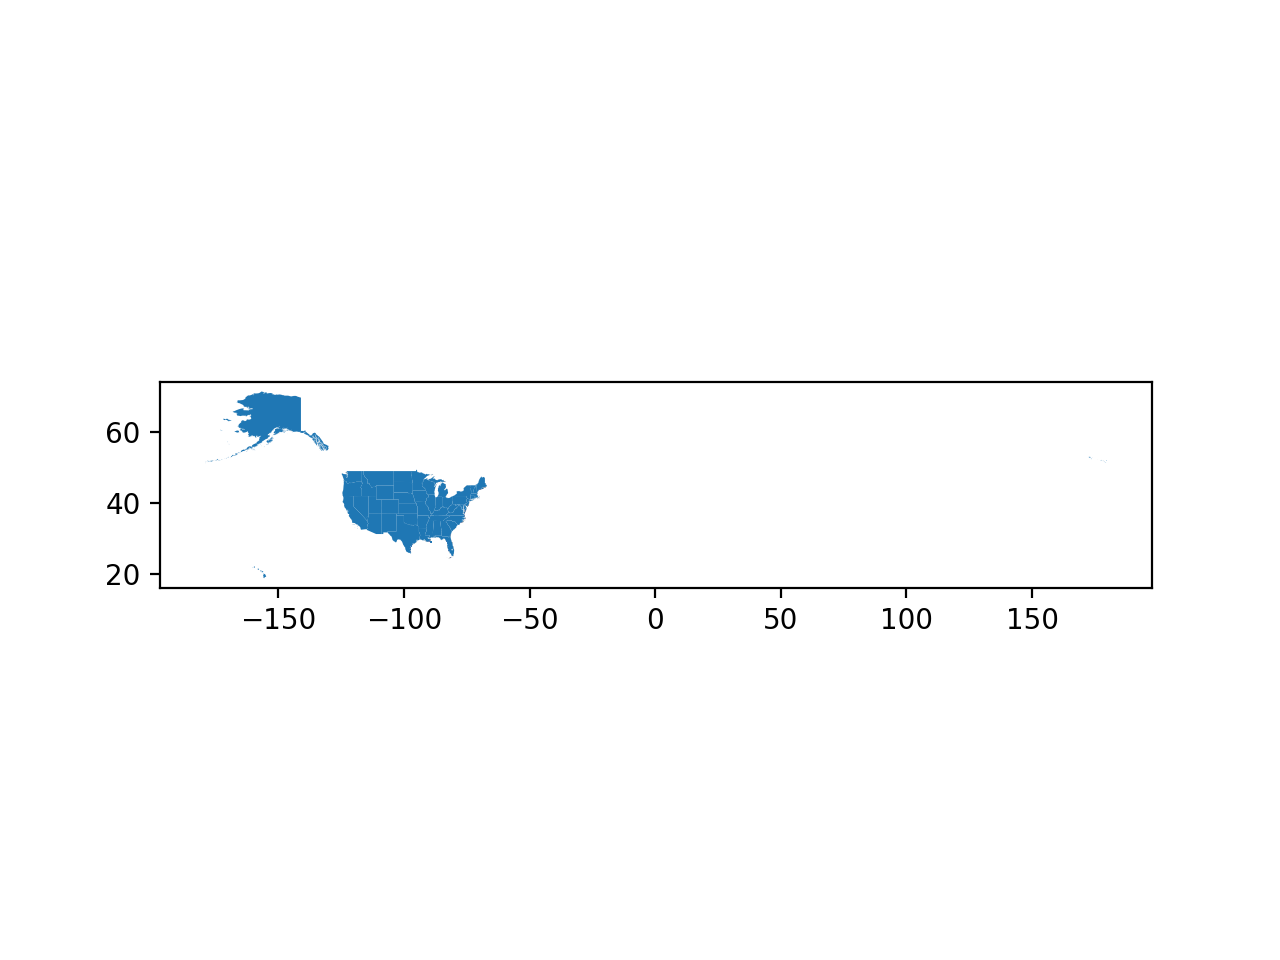

<Axes: >

In [87]:
gdf.plot()

We see the issue here - due to Alaska and Hawaii, we are unable to get a closer look at the US. We will remove these and add them separately to our final graph

### Clipping Alaska and Hawaii
Creating a dataset that will only include the business applications from 2022 as a column

In [114]:
df_diff = df_biz[['STATE','2005','2022']].copy()
df_diff = df_diff.rename(columns={"2005":"BA_2005", "2022":"BA_2022"})
df_diff.head()

,STATE,BA_2005,BA_2022
0,AL,31078,70750
1,AK,4730,8456
2,AZ,56547,115080
3,AR,19133,37562
4,CA,271636,485954


We are going to clip Hawaii and Alaska and add them separately. 

<IPython.core.display.Javascript object>


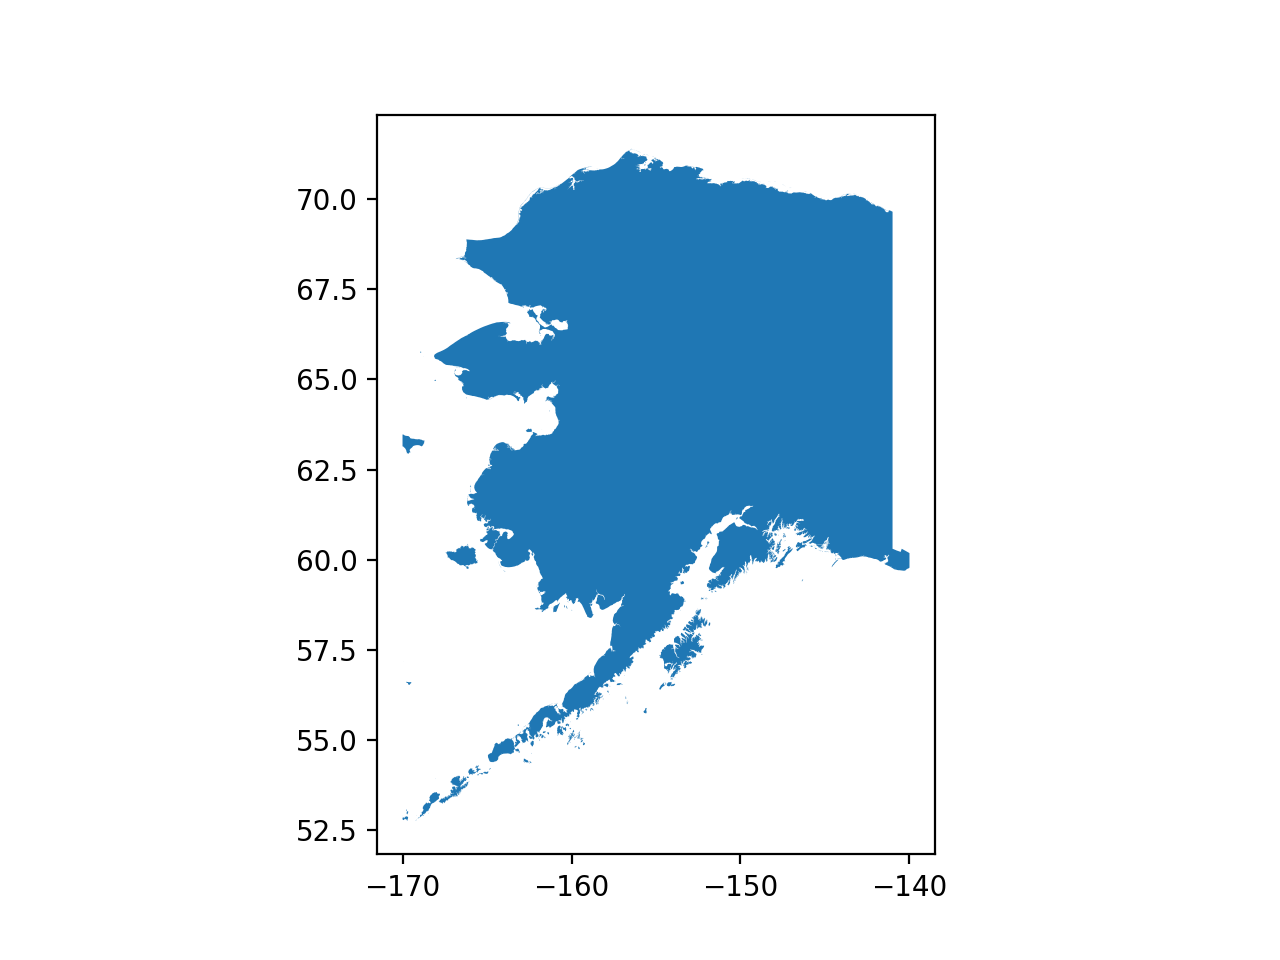

<Axes: >

In [115]:
alaska_gdf = gdf[gdf.STATE=='AK']
alaska_gdf = alaska_gdf.merge(df_diff, on="STATE")
#clipping some of the western islands to make it fit better
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = alaska_gdf.clip(polygon)
alaska_gdf.plot() 

<IPython.core.display.Javascript object>


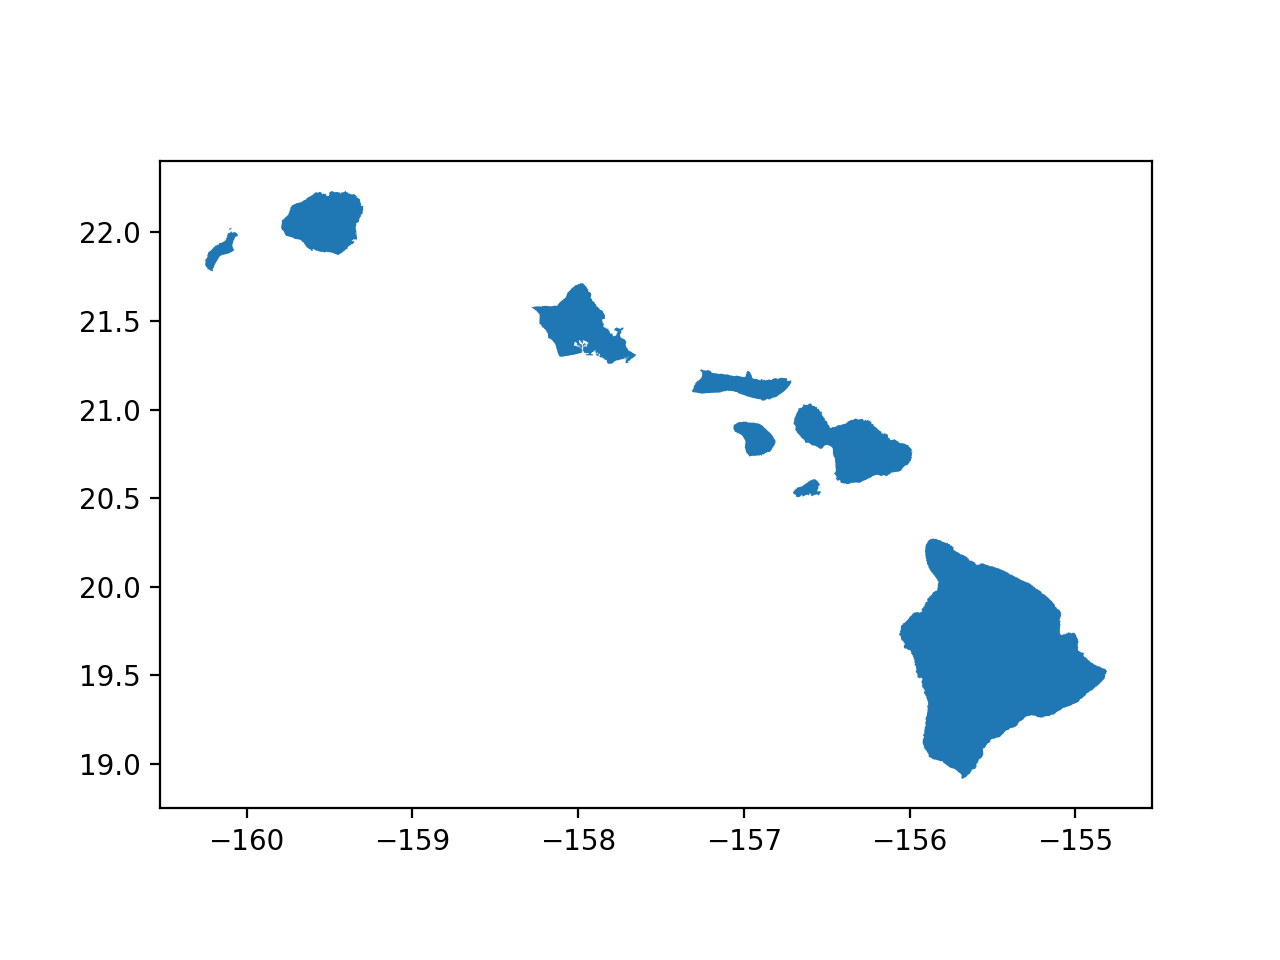

<Axes: >

In [116]:
hawaii_gdf = gdf[gdf.STATE=='HI']
hawaii_gdf = hawaii_gdf.merge(df_diff, on="STATE")
hawaii_gdf
hawaii_gdf.plot()

Removing Alaska and Hawaii from the table due to mapping errors. Will add back later separately.

In [117]:
gdf_map = gdf.drop(gdf[gdf['STATE'] == 'AK'].index)
gdf_map = gdf_map.drop(gdf_map[gdf_map['STATE'] == 'HI'].index)
len(gdf_map)

49

In [118]:
gdf_new = gdf_map.merge(df_diff, on="STATE")
gdf_new.head()

,STATE,NAME,FIPS,LON,LAT,geometry,BA_2005,BA_2022
0,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ...",31078,70750
1,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",19133,37562
2,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0...",56547,115080
3,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263...",271636,485954
4,CO,Colorado,08,-105.54783,38.99855,"POLYGON ((-106.87560 41.00301, -106.85850 41.0...",55916,115689


In [119]:
alaska_gdf

,STATE,NAME,FIPS,LON,LAT,geometry,BA_2005,BA_2022
0,AK,Alaska,02,-152.255721,64.242373,"MULTIPOLYGON (((-169.16139 52.79556, -169.1610...",4730,8456


In [124]:
print(gdf_new['BA_2022'].max())
print(gdf_new['BA_2005'].max())

607279
281702


Plotting the values on a geographical map we get a heatmap:

<IPython.core.display.Javascript object>


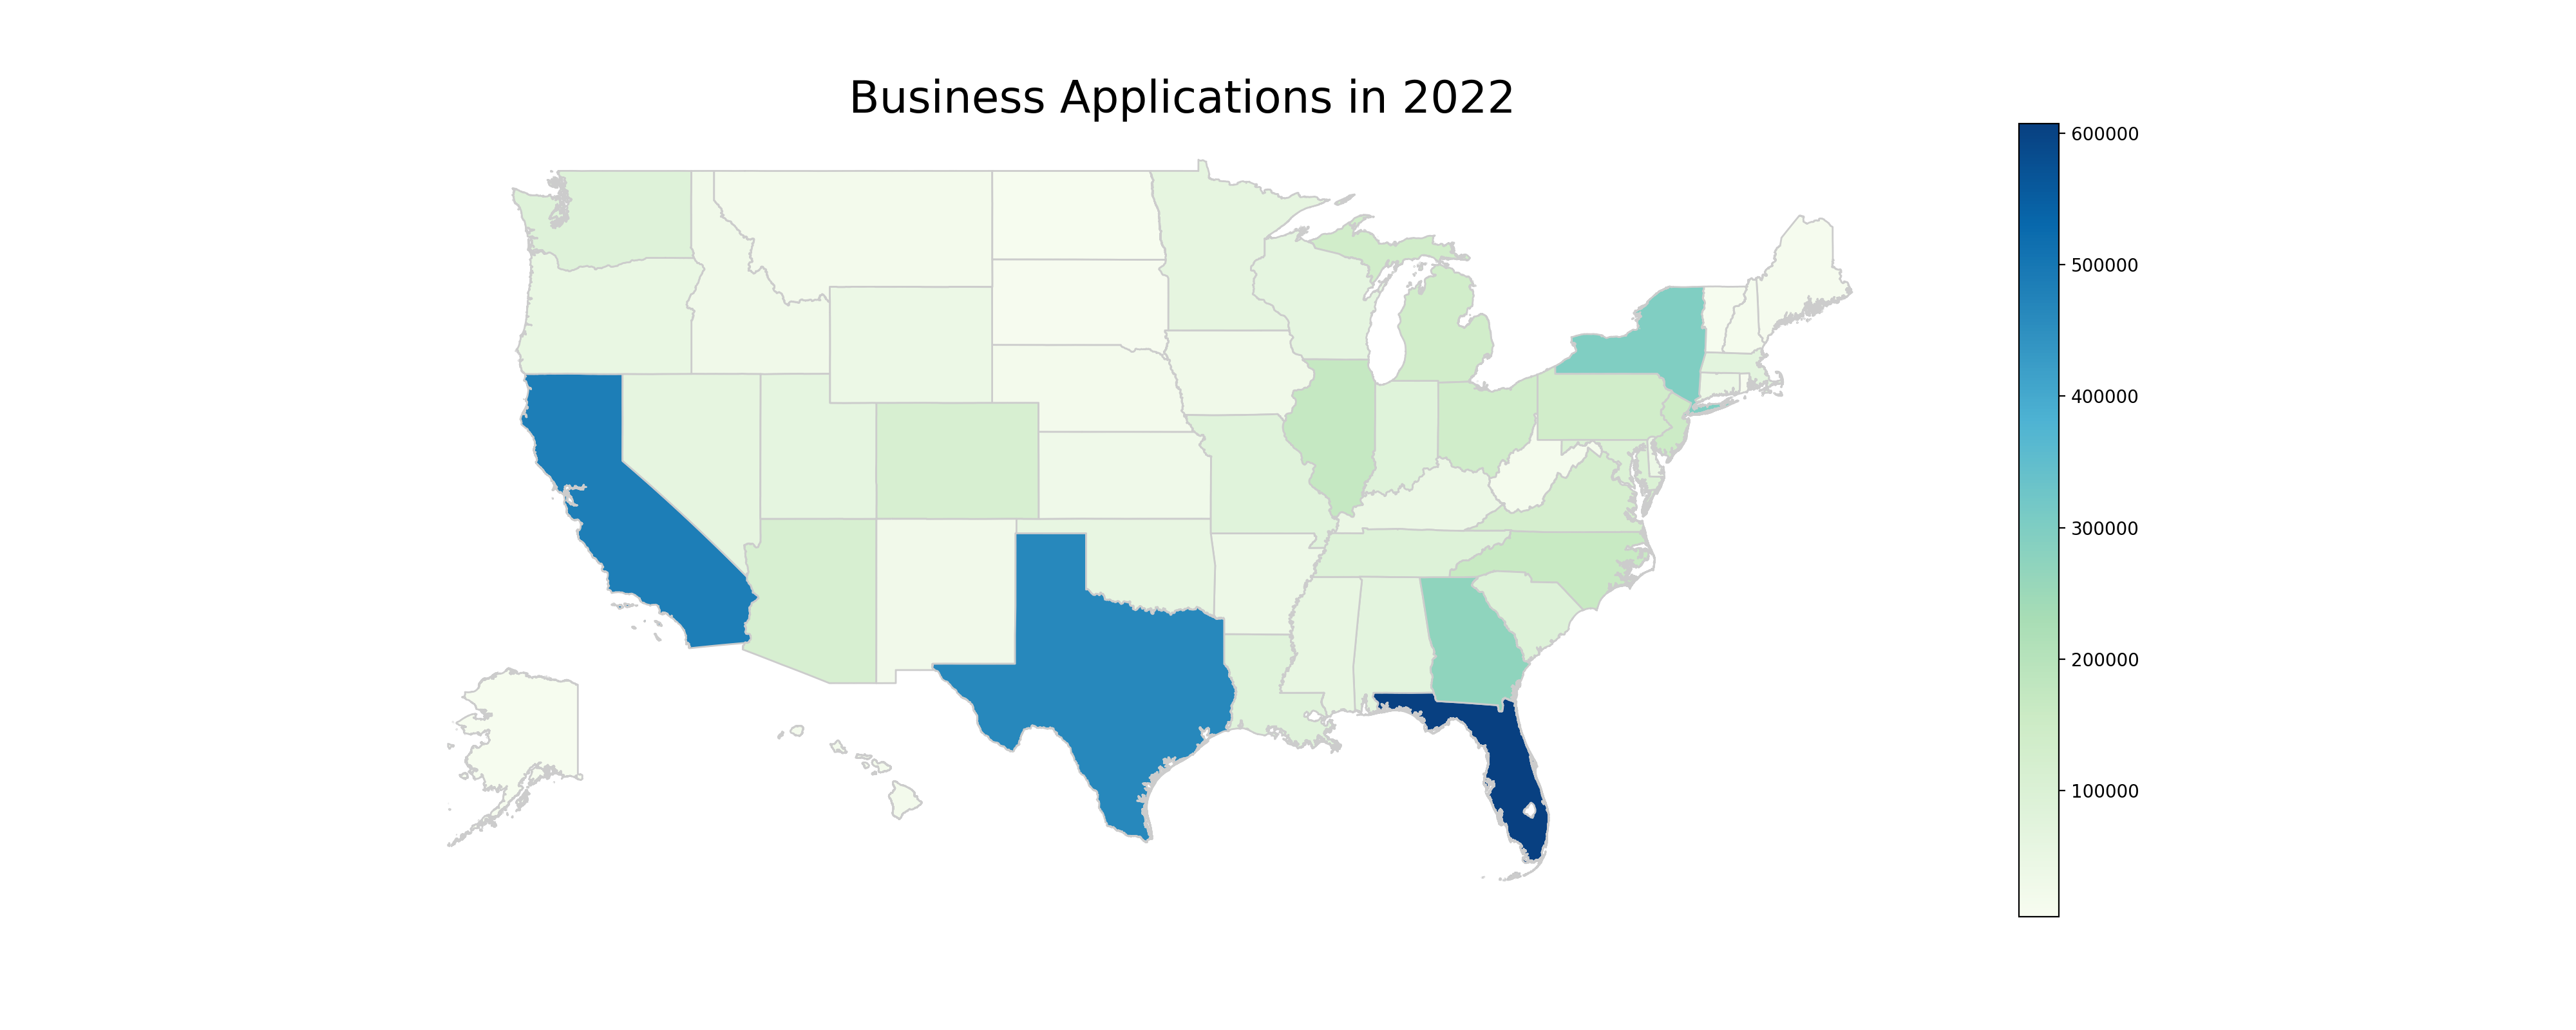

<Axes: >

In [132]:
# Print the map for 2022
# Set the range for the choropleth
title = 'Business Applications in 2022'
col = 'BA_2022'
vmin = gdf_new['BA_2005'].min()
vmax = gdf_new['BA_2022'].max()
cmap = 'GnBu'
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))
# Remove the axis
ax.axis('off')
gdf_new.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap, legend=True, vmin = vmin, vmax=vmax)
# Add a title
ax.set_title(title, fontdict={'fontname': 'Calibri Light','fontsize': '25', 'fontweight': '3'})
# Create an annotation for the data source

#Add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
alaska_gdf.plot(column=alaska_gdf[col], cmap="GnBu", ax=akax, linewidth=1, edgecolor='0.8', vmin = vmin, vmax=vmax)

#Add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])      
hiax.axis('off')
hawaii_gdf.plot(column=hawaii_gdf[col], cmap="GnBu", ax=hiax, linewidth=1, edgecolor='0.8', vmin = vmin, vmax=vmax)



<IPython.core.display.Javascript object>


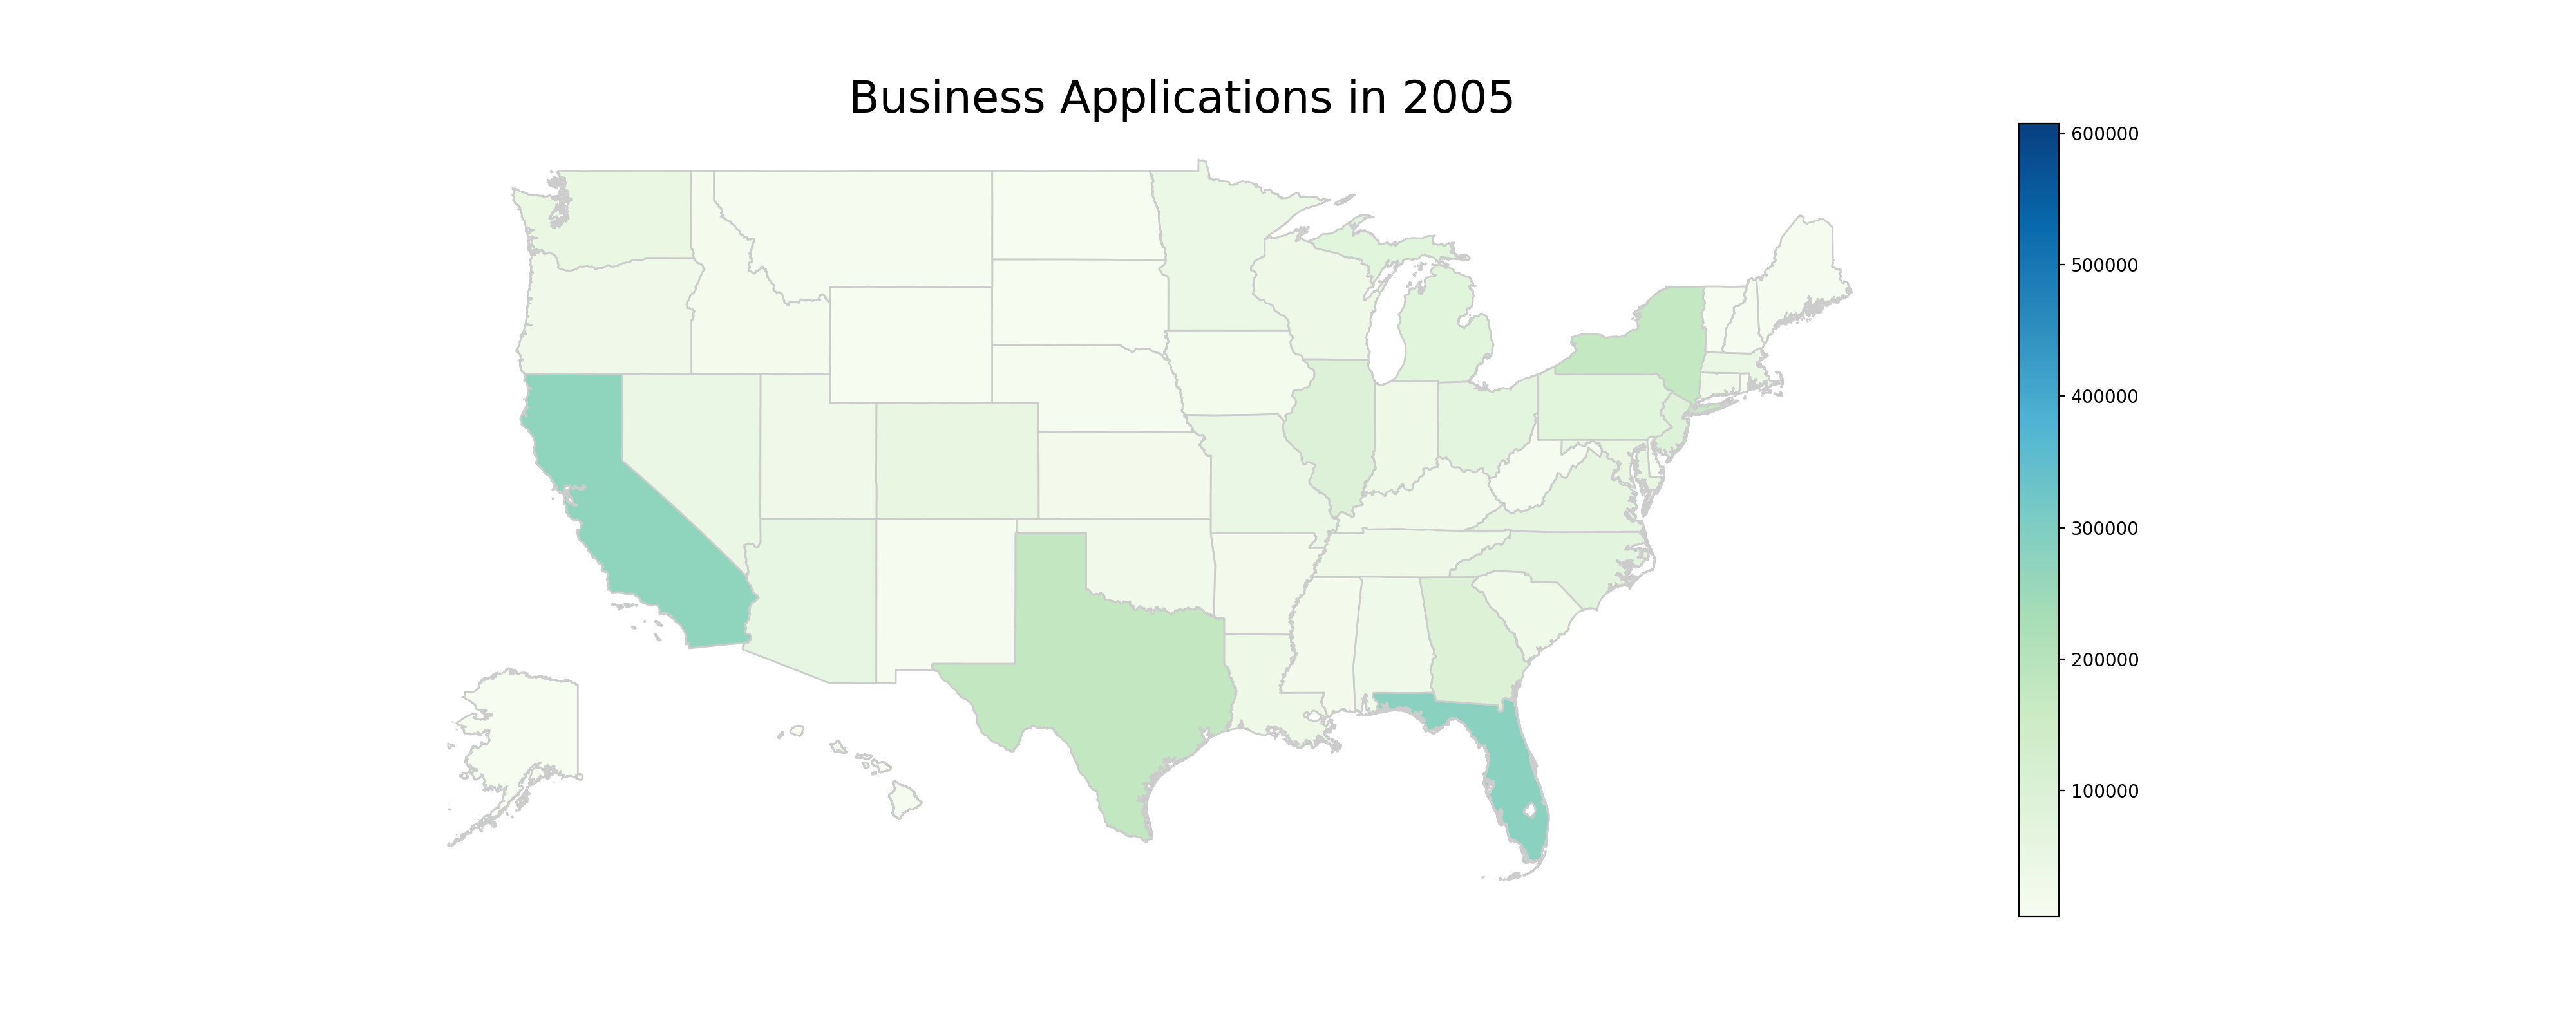

<Axes: >

In [133]:
# Print the map for 2005
# Set the range for the choropleth
title = 'Business Applications in 2005'
col = 'BA_2005'
vmin = gdf_new['BA_2005'].min()
vmax = gdf_new['BA_2022'].max()
cmap = 'GnBu'
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))
# Remove the axis
ax.axis('off')
gdf_new.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap, legend=True, vmin = vmin, vmax=vmax)
# Add a title
ax.set_title(title, fontdict={'fontname': 'Calibri Light','fontsize': '25', 'fontweight': '3'})
# Create an annotation for the data source

#Add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
alaska_gdf.plot(column=alaska_gdf[col], cmap="GnBu", ax=akax, linewidth=1, edgecolor='0.8', vmin = vmin, vmax=vmax)

#Add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])      
hiax.axis('off')
hawaii_gdf.plot(column=hawaii_gdf[col], cmap="GnBu", ax=hiax, linewidth=1, edgecolor='0.8', vmin = vmin, vmax=vmax)



## Trends

### Importing the data used to create charts 

Using the combined.csv from data cleaning to get consolidated information

In [138]:
combined_data_new = pd.read_csv("combined.csv")
combined_data_new.head()

,State,year,tax_rate,business_applications,gdp,min_wage,unemployment_rate,population,median_hh_income
0,Alabama,2005,6.5,31078,1.588500e+11,5.15,4.5,4569805,53550
1,Alabama,2006,6.5,33918,1.664700e+11,5.15,4.0,4628981,53170
2,Alabama,2007,6.5,33701,1.729800e+11,5.15,4.0,4672840,57660
3,Alabama,2008,6.5,32222,1.745300e+11,6.55,5.7,4718206,58600
4,Alabama,2009,6.5,29221,1.709300e+11,7.25,11.0,4757938,52890


Taking top 5 states with the largest number of business applications in 2022

In [158]:
select_df = combined_data_new[combined_data_new['year'] == 2022].reset_index(drop=True)
select_df = select_df.sort_values(by=['business_applications'])
select_df = select_df.tail()
selected_states = select_df['State'].tolist()
selected_states

['Georgia', 'New York', 'Texas', 'California', 'Florida']

In [243]:
col_list = list(select_df.columns)

del col_list[0] #deleting 'State'
del col_list[0] #deleting 'year'

print(col_list)

['tax_rate', 'business_applications', 'gdp', 'min_wage', 'unemployment_rate', 'population', 'median_hh_income']


Mapping the trends for the top 5 states

<IPython.core.display.Javascript object>


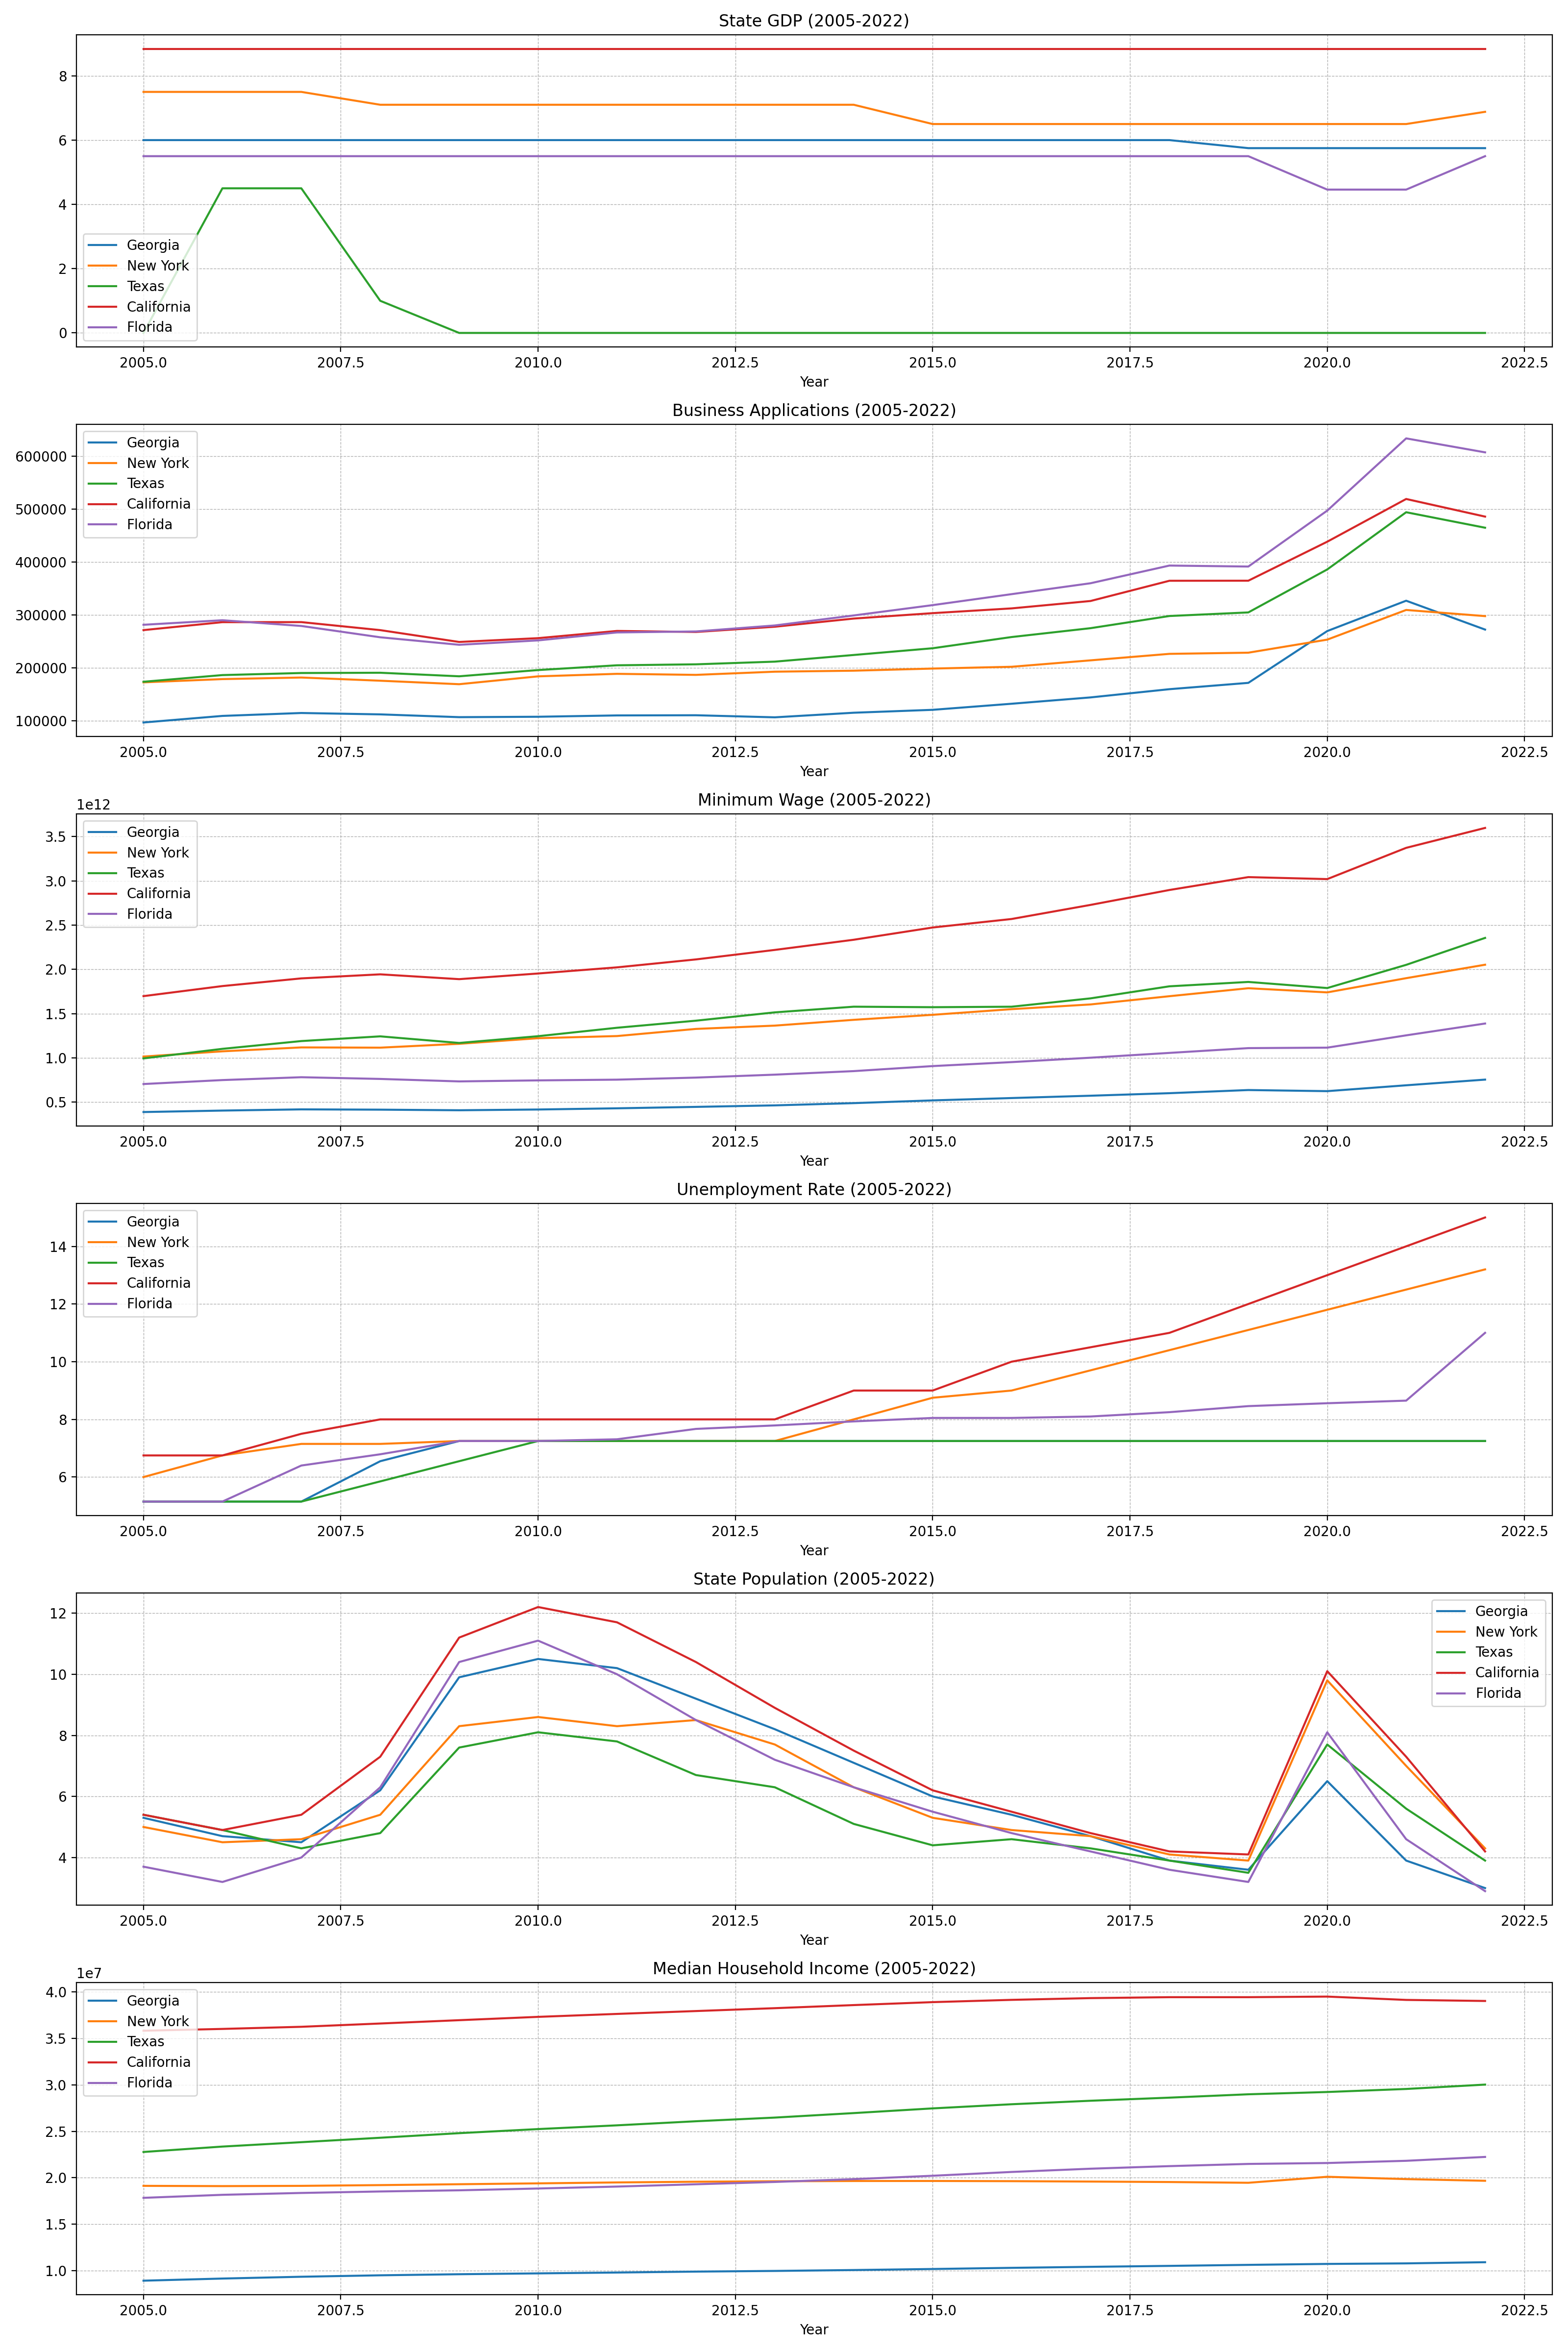

In [244]:
# Setting up a multi-plot grid for visualization
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(16, 24))

# Time Series Plot for the selected variables
titles = [
    'State GDP (2005-2022)', 
    'Business Applications (2005-2022)', 
    'Minimum Wage (2005-2022)', 
    'Unemployment Rate (2005-2022)', 
    'State Population (2005-2022)', 
    'Median Household Income (2005-2022)'
]

for idx, (var, title) in enumerate(zip(col_list, titles)):
    for state in selected_states:
        state_data = combined_data_new[combined_data_new['State'] == state]
        axes[idx].plot(state_data['year'], state_data[var], label=state)
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Year')
    axes[idx].legend()
    axes[idx].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


Here are the trends from for the selected states: California, Texas, Florida, New York, and Georgia for the given years 2005 to 2022 

- Trend in GDP: Most states show a general positive trend in GDP, with some fluctuations such as the financial crisis of 2008 and the COVID pandemic in 2020. Texas and California, in particular, have a notable increase in GDP over the years.
- Trend in Business Applications: We observe spikes in business applications around 2020 for most states. According to the University of Maryland, there was a surge in Americans starting businesses during and after the pandemic. The new companies range from restaurants and dry cleaners to high-tech start-ups. (source: https://www.nytimes.com/2023/09/29/us/politics/pandemic-economy-surge-start-ups.html) 
- Trend in Minimum Wage: There's an upward trend in minimum wage for all states.
- Trend in Unemployment Rate: There are fluctuations in the unemployment rate, with spikes observed around the financial crisis of 2008 and the COVID pandemic in 2020.
- Trend in Population: The population generally grows over time, with Texas and Florida showing significant growth.
- Trend in Median Household Income: There's an upward trend in median household income for all states.


##  Number of Business Applications over time for 5 states with change in tax rate

In [217]:
biz_apps_highest = df_biz.nlargest(5,"2022")
biz_apps_highest = df_biz.set_index('Name')
biz_apps_highest = biz_apps_highest.drop(columns=['STATE'])
biz_apps_highest.head()

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Name,,,,,,,,,,,,,,,,,,
Alabama,31078,33918,33701,32222,29221,29916,28994,29694,29331,29574,31506,34286,36760,41948,41478,58557,75443,70750
Alaska,4730,5229,5138,4979,4396,4661,5083,5210,5383,5447,5901,6358,7263,9238,8118,8063,8063,8456
Arizona,56547,63067,64673,62972,58279,57926,57837,55305,55516,56401,57176,61448,67833,73424,76539,89957,113142,115080
Arkansas,19133,20400,19630,18707,17927,17843,17939,17812,17551,18445,19033,20445,23135,25678,25473,32314,41599,37562
California,271636,286652,286737,271606,249246,256436,270057,268103,278014,293443,303657,312636,326592,364807,364924,438554,519236,485954


### Florida

In [206]:
# Excluding the non-numeric 'State.1' column and plotting the data for Florida
fl_plot = biz_apps_highest.loc['Florida', '2005':'2022'].plot(kind='line', figsize=(10, 6), lw=2.5)

# Setting labels and title
fl_plot.set_ylabel('Business Applications (K)')
fl_plot.set_xlabel('Time')
fl_plot.set_title('Business Applications over time in Florida')
plt.xticks(rotation=45) # Rotate years for better readability

# Adding vertical lines for 2019 and 2020
fl_plot.axvline(x=biz_apps_highest.columns.get_loc('2019') - 2, color='green', linestyle='-', linewidth=2,
                label="Tax rate change: 5.50% to 4.46%")

#plt.xticks(ticks=range(len(fl_plot.index)), labels=fl_data.index, rotation=45)  # Display every year on x-axis
plt.xticks(ticks=range(len(biz_apps_highest.columns[1:])), labels=biz_apps_highest.columns[1:], rotation=45)



# Change absolute number of business applications by giving it in thousands
fl_plot.set_yticks(fl_plot.get_yticks())
fl_plot.set_yticklabels([int(y/1000) for y in fl_plot.get_yticks()])

# Change y-axis limit using buffer 
buffer = 0.05  # 5% buffer
fl_min = biz_apps_highest.loc['Florida', '2005':'2022'].min()
fl_max = biz_apps_highest.loc['Florida', '2005':'2022'].max()
fl_plot.set_ylim(fl_min - buffer * fl_min, fl_max + buffer * fl_max)

# Implement gridlines
fl_plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='black', alpha=0.6)

# Showing the legend and the plot
fl_plot.legend()
plt.show()

### California

In [207]:
# Setting the 'State' column as the index for the biz_apps_highest dataframe
biz_apps_highest = df_biz.set_index('Name')

# Excluding the non-numeric 'State.1' column and plotting the data for California
ca_plot = biz_apps_highest.loc['California', '2005':'2022'].plot(kind='line', figsize=(10, 6), lw=2.5)

# Setting labels and title
ca_plot.set_ylabel('Business Applications (K)')
ca_plot.set_xlabel('Time')
ca_plot.set_title('Business Applications over time in California')
plt.xticks(rotation=45) # Rotate years for better readability

# Set x-axis to include every year in the data
plt.xticks(ticks=range(len(biz_apps_highest.columns[1:])), labels=biz_apps_highest.columns[1:], rotation=45)


# Change absolute number of business applications by giving it in thousands
ca_plot.set_yticks(ca_plot.get_yticks())
ca_plot.set_yticklabels([int(y/1000) for y in ca_plot.get_yticks()])

# Change y-axis limit using buffer 
buffer = 0.05  # 5% buffer
ca_min = biz_apps_highest.loc['California', '2005':'2022'].min()
ca_max = biz_apps_highest.loc['California', '2005':'2022'].max()
ca_plot.set_ylim(ca_min - buffer * ca_min, ca_max + buffer * ca_max)

# Implement gridlines
ca_plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='black', alpha=0.6)

# Showing the legend and the plot
ca_plot.legend()
plt.show()


### Texas

In [223]:

tx_plot = biz_apps_highest.loc['Texas', '2005':'2022'].plot(kind='line', figsize=(10, 6), lw=2.5)

# Setting labels and title
tx_plot.set_ylabel('Business Applications (K)')
tx_plot.set_xlabel('Time')
tx_plot.set_title('Business Applications over time in Texas')

# Set xticks to every year in the data
plt.xticks(ticks=range(len(biz_apps_highest.columns[1:])), labels=biz_apps_highest.columns[1:], rotation=45)

# Adding vertical lines for 2006, 2008, and 2009 indicating tax rate change
tx_plot.axvline(x = biz_apps_highest.columns.get_loc('2006'), color='red', linestyle='-', linewidth=2, label='Tax rate increase: 0% -> 4.50%')
tx_plot.axvline(x = biz_apps_highest.columns.get_loc('2008'), color='green', linestyle='--', linewidth=2, label='Tax rate decrease: 4.50% -> 1.00%')
tx_plot.axvline(x = biz_apps_highest.columns.get_loc('2009'), color='green', linestyle='--', linewidth=2, label='Tax rate decrease: 1.00% -> 0.00%')

# Change absolute number of business applications by giving it in thousands
tx_plot.set_yticks(tx_plot.get_yticks())
tx_plot.set_yticklabels([int(y/1000) for y in tx_plot.get_yticks()])


# Change y-axis limit using buffer 
buffer = 0.05  # 5% buffer
tx_min = biz_apps_highest.loc['Texas'].min()
tx_max = biz_apps_highest.loc['Texas'].max()
tx_plot.set_ylim(tx_min - buffer * tx_min, tx_max + buffer * tx_max)

# Implement gridlines
tx_plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='black', alpha=0.6)

# Showing the legend and the plot
tx_plot.legend()
plt.show()

### New York

In [222]:
ny_plot = biz_apps_highest.loc['New York', '2005':'2022'].plot(kind='line', figsize=(10, 6), lw=2.5)
#ny_plot = biz_apps_highest.loc['New York'].plot(kind='line', figsize=(10, 6), lw = 2.5)

# Setting labels and title
ny_plot.set_ylabel('Business Applications (K)')
ny_plot.set_xlabel('Time')
ny_plot.set_title('Business Applications over time in New York')

# Set xticks to every year in the data
plt.xticks(ticks=range(len(biz_apps_highest.columns[1:])), labels=biz_apps_highest.columns[1:], rotation=45)

# Adding vertical lines for 2019 and 2020
ny_plot.axvline(x = biz_apps_highest.columns.get_loc('2008'), color='green', linestyle='--', linewidth=2.5, label='Tax rate decrease: 7.50% -> 7.10%')
ny_plot.axvline(x = biz_apps_highest.columns.get_loc('2015'), color='green', linestyle='--', linewidth=2.5, label='Tax rate decrease: 7.10% -> 6.50%')


# Change absolute number of business applications by giving it in thousands
ny_plot.set_yticks(ny_plot.get_yticks())
ny_plot.set_yticklabels([int(y/1000) for y in ny_plot.get_yticks()])

# Change upper limit of 
#ny_plot.set_ylim(200 * 1000, 650 * 1000)
buffer = 0.05  # 5% buffer
ny_min = biz_apps_highest.loc['New York'].min()
ny_max = biz_apps_highest.loc['New York'].max()
ny_plot.set_ylim(ny_min - buffer * ny_min, ny_max + buffer * ny_max)


# Introudce gridlines
ny_plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='black', alpha=0.6)

# Showing the legend and the plot
ny_plot.legend()
plt.show()


### Georgia

In [220]:

# Plotting the data
ga_plot = biz_apps_highest.loc['Georgia', '2005':'2022'].plot(kind='line', figsize=(10, 6), lw=2.5)
#ga_plot = biz_apps_highest.loc['Georgia'].plot(kind='line', figsize=(10, 6), lw = 2.5, label = "Number of Business Applications in Georgia")

# Setting labels and title
ga_plot.set_ylabel('Business Applications (K)')
ga_plot.set_xlabel('Time')
ga_plot.set_title('Business Applications over time in Georgia')

# Set xticks to every year in the data
plt.xticks(ticks=range(len(biz_apps_highest.columns[1:])), labels=biz_apps_highest.columns[1:], rotation=45)

# Adding vertical lines for 2018 indicating decrease in tax rate
ga_plot.axvline(x = biz_apps_highest.columns.get_loc('2018'), color='green', linestyle='--', linewidth=2.5, label='Tax rate decrease: 6.00% -> 5.75%')

# Change absolute number of business applications by giving it in thousands
#ga_plot.set_yticks(ax.get_yticks())
#ga_plot.set_yticklabels([int(y/1000) for y in fl_plot.get_yticks()])


# Change upper limit of 
#ny_plot.set_ylim(200 * 1000, 650 * 1000)
buffer = 0.05  # 5% buffer
ga_min = biz_apps_highest.loc['Georgia'].min()
ga_max = biz_apps_highest.loc['Georgia'].max()
ga_plot.set_ylim(ga_min - buffer * ga_min, ga_max + buffer * ga_max)

# Introudce gridlines
ga_plot.grid(True, which='both', linestyle='--', linewidth=0.5, color='black', alpha=0.6)

# Showing the legend and the plot
ga_plot.legend()
plt.show()